### Measuring correlations between trip flows X points of interest grouped by similarity
##### This notebook compares number of trips per grid cell and points of interest from Google Places. 
##### Different from the [Correlations](Correlations.ipynb) notebook, we grouped POIs by categories.
##### We use Pearson's correlation coefficient and predictive power score in this comparison. 
##### Questions:
* How is the correlation between a POI group and the number of bike trips that start or end in the grid cells?
* How is the impact of independent variables on the correlation? The evaluated variables are: cell as origin or destination of the trips, grid size, day period, year period

In [1]:
import pandas as pd
import seaborn as sns
import ppscore as pps
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import bikescience.load_trips as tr
import bikescience.stations as st
import bikescience.grid as grid
import bikescience.flow as flow
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings('ignore')

#### Auxiliary functions

In [2]:
def heatmap_corr(df):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

def heatmap_pps(df):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

#### Loading trips

In [3]:
trips = tr.load_all_trips('../data/boston/bike-trips')
print(len(trips), 'trips')
stations = st.load('../data/boston/bike-stations/stations.geojson')
print(len(stations), 'stations')

9427775 trips
324 stations


#### Filtering trips

In [4]:
filtered_trips = trips

#only working days
filtered_trips = tr.working_days(filtered_trips)

# after a date
#filtered_trips = trips[trips.starttime >= pd.Timestamp('2018-01-01 00:00:0000')]

# between April and November of all years
#filtered_trips = trips[((trips.starttime >= pd.Timestamp('2018-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2018-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2019-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2019-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2017-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2017-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2016-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2016-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2015-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2015-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2014-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2014-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2013-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2013-12-01 00:00:0000'))) | \
#                      ((trips.starttime >= pd.Timestamp('2012-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2012-12-01 00:00:0000'))) ]
print(len(filtered_trips), 'trips')

7007719 trips


#### Creating the OD matrix

In [91]:
the_grid = grid.Grid(n=10)
od = flow.od_countings(filtered_trips, the_grid, stations)
od.drop(columns=['origin','destination'],inplace=True)
od.head()

/home/higor/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


i_start  j_start  i_end  j_end  trip counts
0        0        3      0      3           25
1        0        3      0      5            4
2        0        3      1      3          387
3        0        3      1      4            7
4        0        3      1      5            7

### POIs

In [92]:
base_folder = '../data/boston/training-sets/'
poi = pd.read_csv(base_folder + 'poi/proportional-grouped-poi-10x10.csv')

In [9]:
poi.columns

Index(['i', 'j', 'placement_id', 'education', 'food_related', 'green_areas',
       'healthcare', 'leisure', 'other', 'services', 'shop', 'transport'],
      dtype='object')

#### Getting POIs per origin cells

In [94]:
poi_od_orig = poi.merge(od, left_on=['i', 'j'],right_on=['i_start','j_start'])
poi_od_orig.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_orig.head()

i  j  placement_id  education  food_related  green_areas  healthcare  \
0  0  3             0         13            41           27         124   
1  0  3             0         13            41           27         124   
2  0  3             0         13            41           27         124   
3  0  3             0         13            41           27         124   
4  0  3             0         13            41           27         124   

   leisure  other  services  shop  transport  trip counts  
0        5     30        82    46         30           25  
1        5     30        82    46         30            4  
2        5     30        82    46         30          387  
3        5     30        82    46         30            7  
4        5     30        82    46         30            7

#### Getting POIs per destination cells

In [95]:
poi_od_dest = poi.merge(od, left_on=['i', 'j'],right_on=['i_end','j_end'])
poi_od_dest.drop(columns=['i_start','j_start','i_end','j_end'],inplace=True)
poi_od_dest.head()

i  j  placement_id  education  food_related  green_areas  healthcare  \
0  0  3             0         13            41           27         124   
1  0  3             0         13            41           27         124   
2  0  3             0         13            41           27         124   
3  0  3             0         13            41           27         124   
4  0  3             0         13            41           27         124   

   leisure  other  services  shop  transport  trip counts  
0        5     30        82    46         30           25  
1        5     30        82    46         30            1  
2        5     30        82    46         30          457  
3        5     30        82    46         30            5  
4        5     30        82    46         30            4

In [101]:
poi_columns = poi_od_orig.columns.tolist()
poi_columns.remove('i')
poi_columns.remove('j')
poi_columns.remove('placement_id')
poi_columns.remove('trip counts')
poi_columns.append('trips')
poi_aggs = {}
for c in poi_columns:
    if c == 'trips':
        poi_aggs[c] = 'sum'
    else:
        poi_aggs[c] = 'first'
poi_aggs

{'education': 'first',
 'food_related': 'first',
 'green_areas': 'first',
 'healthcare': 'first',
 'leisure': 'first',
 'other': 'first',
 'services': 'first',
 'shop': 'first',
 'transport': 'first',
 'trips': 'sum'}

#### Choosing origin or destination cells to correlate with POIs

In [102]:
poi_od = poi_od_orig.copy()
poi_od = poi_od.rename(columns={'trip counts': 'trips'})
poi_columns.append('i')
poi_columns.append('j')
poi_od = poi_od[poi_columns]
poi_od.head()

education  food_related  green_areas  healthcare  leisure  other  services  \
0         13            41           27         124        5     30        82   
1         13            41           27         124        5     30        82   
2         13            41           27         124        5     30        82   
3         13            41           27         124        5     30        82   
4         13            41           27         124        5     30        82   

   shop  transport  trips  i  j  
0    46         30     25  0  3  
1    46         30      4  0  3  
2    46         30    387  0  3  
3    46         30      7  0  3  
4    46         30      7  0  3

In [103]:
poi_od = poi_od.groupby(['i','j'], as_index=False).agg(poi_aggs)
poi_od.drop(columns=['i','j'],inplace=True)
poi_od.head(10)

education  food_related  green_areas  healthcare  leisure  other  services  \
0         13            41           27         124        5     30        82   
1         21            57           19          72        6     55       129   
2         14           114           15          87        9     25       231   
3         19            55           15         120       17     32       121   
4         13            28           14          39        4     31        58   
5         16            41           19          59        2     47       115   
6         14            52           21          61        5     34       119   
7         12             9            7          21        6     11        32   
8          7            10            6          40        2      9        28   
9         14            24           23         109        4     34        61   

   shop  transport  trips  
0    46         30    934  
1    83         65   1680  
2   168         77    487  
3    66         23  29033  
4    57         30   7397  
5    62         41   3569  
6    80         56  10015  
7    10         15   6592  
8    24         15    727  
9    47         30  21005

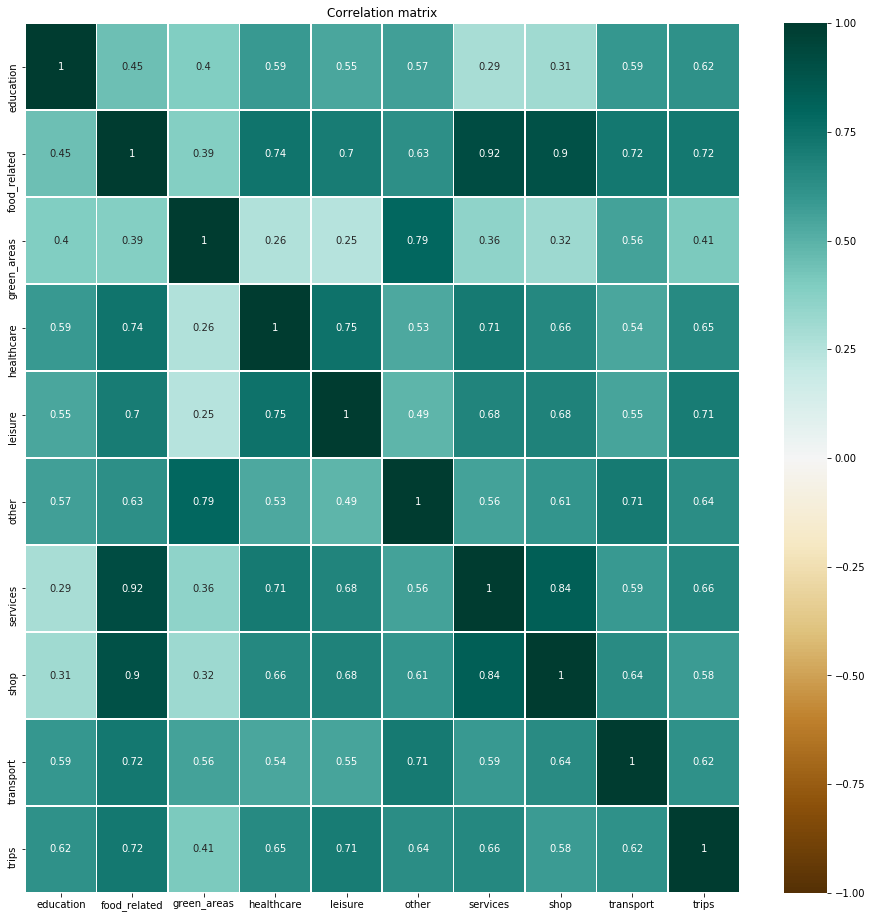

In [105]:
heatmap_corr(poi_od.corr())

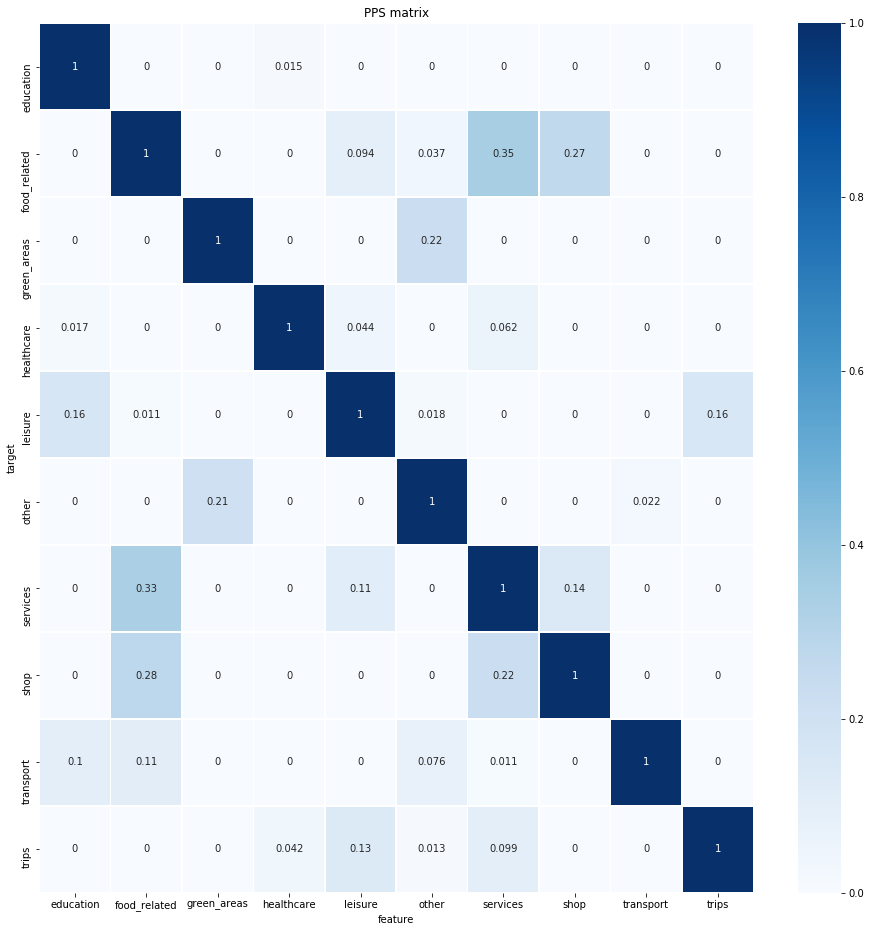

In [104]:
heatmap_pps(pps.matrix(poi_od))